In [2]:
# standards imports 
from typing import TypedDict, Literal

# third-party imports
from langgraph.graph import StateGraph, START, END

In [3]:
# state for the Quadratic Graph
class QuadState(TypedDict):
    """
    Represents the state of a graph that solves a quadratic equation.
    It holds all the variables necessary to compute and store the solution.

    Args:
        TypedDict: Base class for type hints.
    """
    # variables for the quadratic equation coefficients
    a : int
    b : int 
    c : int
    
    # the discriminant of the quadratic equation (b^2 - 4ac)
    discriminant : float
    
    # string representation of the equation
    equation : str 
    
    # the final result of the equation
    result : str

In [21]:
# node functions for the graph

# 1. showing equation 
def show_equation(state: QuadState):
    """
    Formats and returns the quadratic equation as a string.
    
    Args:
        state: Current state containing coefficients a, b, c
        
    Returns:
        Dictionary with formatted equation string
    """
    equation = f"{state['a']}x^2 + {state['b']}x + {state['c']}"
    return {'equation': equation}

# 2. calculating discriminant 
def calculate_discriminant(state: QuadState):
    """
    Calculates the discriminant (b^2 - 4ac) of the quadratic equation.
    
    Args:
        state: Current state containing coefficients a, b, c
        
    Returns:
        Dictionary with calculated discriminant value
    """
    discriminant = (state['b']**2) - (4 * state['a'] * state['c'])
    
    return {'discriminant': discriminant}

# 3. find real roots
def find_real_roots(state: QuadState):
    """
    Calculates two distinct real roots when discriminant > 0.
    
    Args:
        state: Current state containing coefficients and discriminant
        
    Returns:
        Dictionary with result string containing both roots
    """
    # calculate both roots using the quadratic formula
    root_1 = (-state['b'] + state['discriminant']**0.5) / (2 * state['a'])
    root_2 = (-state['b'] - state['discriminant']**0.5) / (2 * state['a'])
    
    result = f"The roots of the equation are {root_1} and {root_2}"
    
    return {'result': result}

# 4. find repeated roots 
def find_repeated_roots(state: QuadState):
    """
    Calculates the repeated root when discriminant = 0.
    
    Args:
        state: Current state containing coefficients and discriminant
        
    Returns:
        Dictionary with result string containing the repeated root
    """
    # when discriminant is 0, both roots are the same
    root = -state['b'] / (2 * state['a'])
    
    result = f"The equation has a repeated root: {root}"
    
    return {'result': result}

# 5. no real roots 
def no_real_roots(state: QuadState):
    """
    Handles case when discriminant < 0 (complex roots).
    
    Args:
        state: Current state containing coefficients and discriminant
        
    Returns:
        Dictionary with result string indicating no real roots
    """
    # calculate complex roots
    real_part = -state['b'] / (2 * state['a'])
    imaginary_part = (abs(state['discriminant'])**0.5) / (2 * state['a'])
    
    result = f"The equation has no real roots. Complex roots are: {real_part} + {imaginary_part}i and {real_part} - {imaginary_part}i"
    
    return {'result': result}

# 6. check condition for graph
def check_root_condition(state: QuadState):
    """
    Determines which path to take based on the discriminant value.
    
    Args:
        state: Current state containing the discriminant
        
    Returns:
        String indicating which node to route to next
    """
    if state['discriminant'] > 0:
        return "find_real_roots"
    elif state['discriminant'] == 0:
        return "find_repeated_roots"
    else:
        return "no_real_roots"


In [22]:
# graph
graph = StateGraph(QuadState)

# add nodes 
graph.add_node("show_equation",show_equation)
graph.add_node("calculate_discriminant",calculate_discriminant)
graph.add_node("find_real_roots",find_real_roots)
graph.add_node("no_real_roots",no_real_roots)
graph.add_node("find_repeated_roots",find_repeated_roots)

# add edges
graph.add_edge(START, "show_equation")
graph.add_edge("show_equation", "calculate_discriminant")

# check discriminant
graph.add_conditional_edges(
	'calculate_discriminant',
	check_root_condition,
	{
		"find_real_roots": "find_real_roots",
		"find_repeated_roots": "find_repeated_roots",
		"no_real_roots": "no_real_roots"
	})

# moving towards the roots
graph.add_edge('find_real_roots',END)
graph.add_edge('find_repeated_roots',END)
graph.add_edge('no_real_roots', END)


workflow = graph.compile()

### 📝 Notes on Conditional Workflows in LangGraph

#### Key Concepts

**1. Conditional Edges**
- Allow dynamic routing between nodes based on runtime state
- Use `add_conditional_edges(source_node, routing_function, path_map)` to define branching logic
- The routing function examines the state and returns a string indicating the next node

**2. Routing Function Requirements**
- Must return a string that **exactly matches** a registered node name
- The returned string determines which node executes next
- Use `Literal` type hints to ensure only valid node names can be returned

**3. Path Mapping (Optional)**
- The dictionary `{"find_real_roots": "find_real_roots", ...}` explicitly maps return values to node names
- When the routing function returns a key, LangGraph routes to the corresponding value
- If omitted, LangGraph assumes the return value directly matches a node name

#### Common Pitfalls & Solutions

**❌ Problem:** TypeError - 'function' object is not iterable
- **Cause:** Passing function objects instead of string node names to `add_edge()`
- **Solution:** Use string names: `add_edge('node_a', 'node_b')` not `add_edge(node_a, node_b)`

**❌ Problem:** ValueError - branch found unknown target
- **Cause:** Routing function returns a string that doesn't match any registered node name
- **Solution:** Ensure exact string matching between return values and node names

**❌ Problem:** Missing path in conditional logic
- **Cause:** Routing function doesn't handle all possible state conditions
- **Solution:** Use if-elif-else to cover all cases or provide explicit path mapping

#### Best Practices

1. **Use Literal Type Hints:** Helps catch mismatches at development time
   ```python
   def router(state) -> Literal["node_a", "node_b", "node_c"]:
       ...
   ```

2. **Consistent Naming:** Keep node names and routing function returns synchronized

3. **Explicit Path Mapping:** When routing logic is complex, use the path_map dictionary for clarity

4. **Document Branches:** Comment which conditions lead to which nodes for maintainability

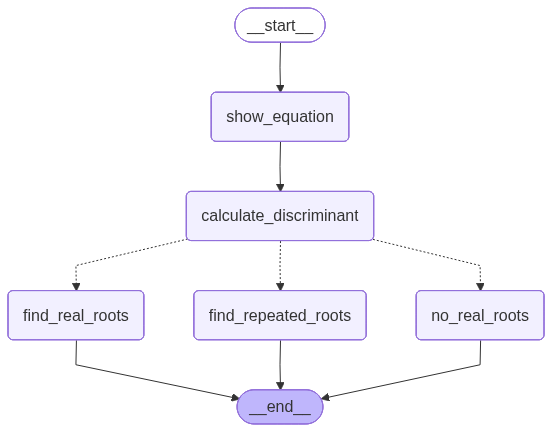

In [23]:
workflow

In [24]:
initial_state = {
    'a': 2, 
    'b': 8,
    'c': 2
}

result = workflow.invoke(initial_state)
print(f"Equation: {result['equation']}")
print(f"Discriminant: {result['discriminant']}")
print(f"Result: {result['result']}")

Equation: 2x^2 + 8x + 2
Discriminant: 48
Result: The roots of the equation are -0.2679491924311228 and -3.732050807568877
